![](../img/banner_day3.png)

<br>

# 3일차 실습(4) - 순환 신경망(RNN)

<br>
<br>
<div align='right'>강사 성민석</div>
<div align='right'>고려대학교 인공지능학과 박사과정</div>
<div align='right'>(minsuksung@korea.ac.kr)</div>

> <font color='red'><b>WARNING</b></font>: 본 컨텐츠는 **[저작권법 제25조 제2항](https://glaw.scourt.go.kr/wsjo/lawod/sjo192.do?contId=2135829&jomunNo=25)** 에 의해 강의 목적으로 이용한 저작물이 포함되어 있습니다.  
> 해당 자료를 제작자의 동의없이 <font color='red'><b>외부에 임의로 공개 및 수정하는 것을 금지</b></font>하며 이를 위반하는 경우 저작권 침해로서 관련법에 따라 처벌될 수 있으니 주의해주시기 바랍니다.

<h1>목차<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터 불러오기</a></span></li><li><span><a href="#데이터셋과-데이터로더-생성하기" data-toc-modified-id="데이터셋과-데이터로더-생성하기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터셋과 데이터로더 생성하기</a></span></li><li><span><a href="#신경망-모델-구성하기" data-toc-modified-id="신경망-모델-구성하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>신경망 모델 구성하기</a></span></li><li><span><a href="#손실-함수-및-최적화-방법-설정하기" data-toc-modified-id="손실-함수-및-최적화-방법-설정하기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>손실 함수 및 최적화 방법 설정하기</a></span></li><li><span><a href="#신경망-학습-및-평가하기" data-toc-modified-id="신경망-학습-및-평가하기-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>신경망 학습 및 평가하기</a></span></li><li><span><a href="#참고자료" data-toc-modified-id="참고자료-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>참고자료</a></span></li></ul></div>

![](../img/pipeline2.png)

In [1]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook

In [2]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
# Set random seed
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [5]:
# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Linux
CUDA: True
Python Version: 3.7.10
torch Version: 1.8.2+cu111
torchvision Version: 0.9.2+cu111


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 데이터 불러오기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [7]:
# pip install -U finance-datareader

In [8]:
import FinanceDataReader as fdr

In [9]:
df = fdr.DataReader('005930', '2000')
df.head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-01-04,6000,6110,5660,6110,1483967,0.148496
2000-01-05,5800,6060,5520,5580,1493604,-0.086743
2000-01-06,5750,5780,5580,5620,1087810,0.007168
2000-01-07,5560,5670,5360,5540,806195,-0.014235
2000-01-10,5600,5770,5580,5770,937615,0.041516
2000-01-11,5820,6100,5770,5770,1194974,0.000000
2000-01-12,5610,5740,5600,5720,584492,-0.008666
2000-01-13,5600,5740,5560,5710,823830,-0.001748
2000-01-14,5720,5880,5680,5830,987576,0.021016


In [10]:
df = df.drop('Change', axis=1)

In [11]:
train_df = df[:'2020']
test_df = df['2020':]

In [12]:
train_df

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,6000,6110,5660,6110,1483967
2000-01-05,5800,6060,5520,5580,1493604
2000-01-06,5750,5780,5580,5620,1087810
2000-01-07,5560,5670,5360,5540,806195
2000-01-10,5600,5770,5580,5770,937615
...,...,...,...,...,...
2020-12-23,72400,74000,72300,73900,19411326
2020-12-24,74100,78800,74000,77800,32502870
2020-12-28,79000,80100,78200,78700,40085044


In [13]:
test_df

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,55500,56000,55000,55200,12993228
2020-01-03,56000,56600,54900,55500,15422255
2020-01-06,54900,55600,54600,55500,10278951
2020-01-07,55700,56400,55600,55800,10009778
2020-01-08,56200,57400,55900,56800,23501171
...,...,...,...,...,...
2022-08-24,59200,59500,59000,59000,8888486
2022-08-25,59200,59700,59000,59700,5767902
2022-08-26,60300,60900,59900,60000,9499995


In [14]:
# from sklearn.preprocessing import MinMaxScaler
# mms_y2 = MinMaxScaler()
# mms_y2.fit([train_df['Close'][5:]])

# mms_y = MinMaxScaler()
# mms_y.fit([test_df['Close'][5:]])

# mms = MinMaxScaler()
# mms.fit(train_df)
# train_df = mms.transform(train_df)
# test_df = mms.transform(test_df)

## 데이터셋과 데이터로더 생성하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [15]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

In [20]:
from torch.utils.data import Dataset, DataLoader

# 데이터셋, 데이터로더 생성하기
class MyDataset(Dataset):
    def __init__(self, df):
        X = []
        y = []
        data = df.values.tolist()

        for idx in range(len(data)):
            if idx < 5:
                continue
            X.append(data[idx-5:idx])
            y.append(data[idx][3])
        
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]).to(device), torch.FloatTensor([self.y[idx]]).to(device)

In [21]:
dataset_train = MyDataset(train_df)
dataset_test = MyDataset(test_df)

In [22]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

## 신경망 모델 구성하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [23]:
# 설정값
data_dim = 5
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 10

In [24]:
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=layers,
            # dropout = 0.1,
            batch_first=True
        )
        self.fc = nn.Linear(
            hidden_dim,
            output_dim,
            bias=True
        )

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [25]:
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)
model

Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

## 손실 함수 및 최적화 방법 설정하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [26]:
criterion = nn.MSELoss().to(device)

In [27]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## 신경망 학습 및 평가하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

0 100 135310016.0
0 200 805740352.0
0 300 1929464832.0


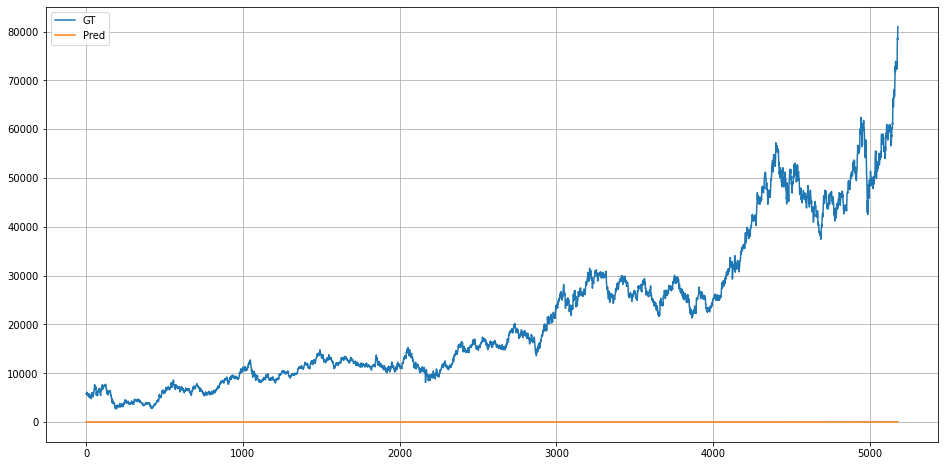

1 100 134926512.0
1 200 804818752.0
1 300 1928071040.0


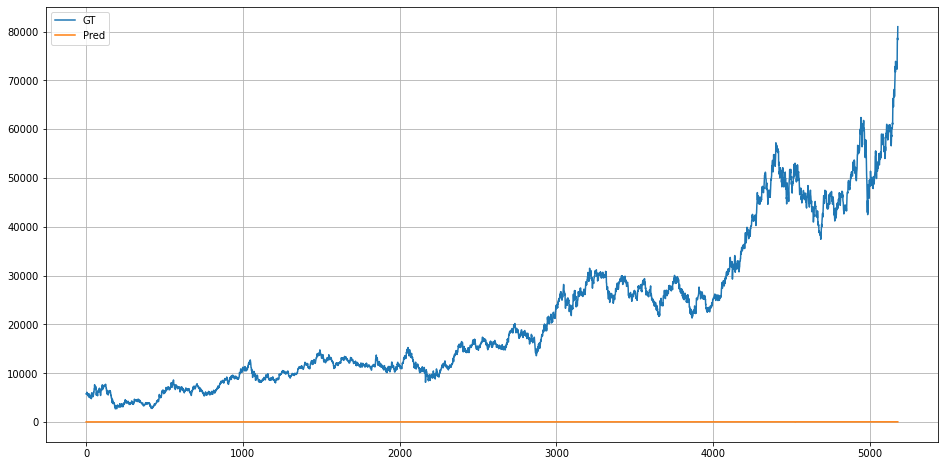

2 100 134559552.0
2 200 803926336.0
2 300 1926703616.0


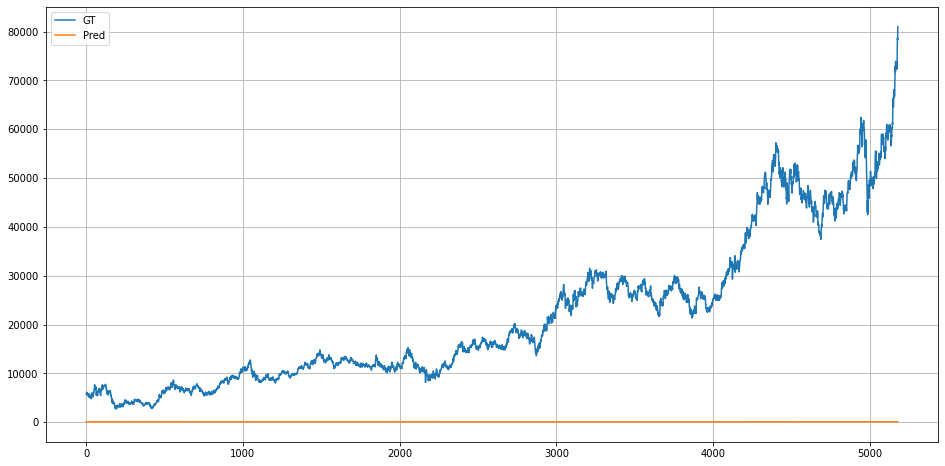

3 100 134198968.0
3 200 803047168.0
3 300 1925348992.0


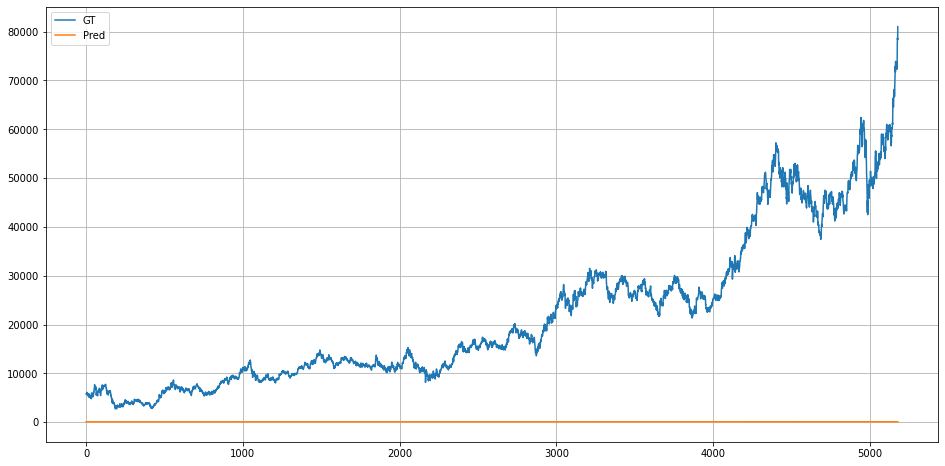

4 100 133842184.0
4 200 802174848.0
4 300 1924002304.0


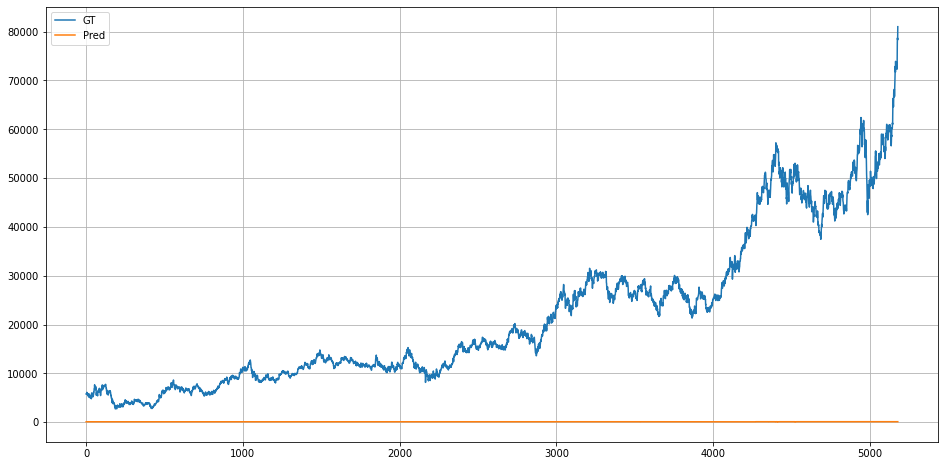

5 100 133487632.0
5 200 801307648.0
5 300 1922662272.0


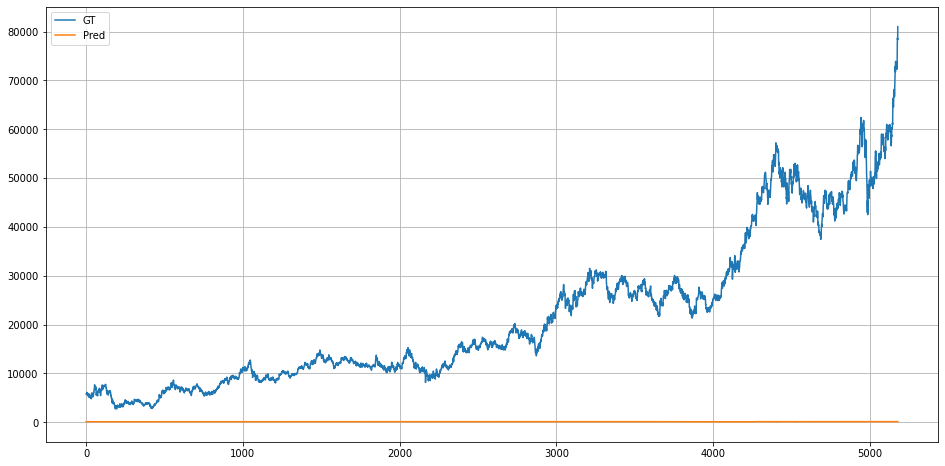

6 100 133134904.0
6 200 800444928.0
6 300 1921325568.0


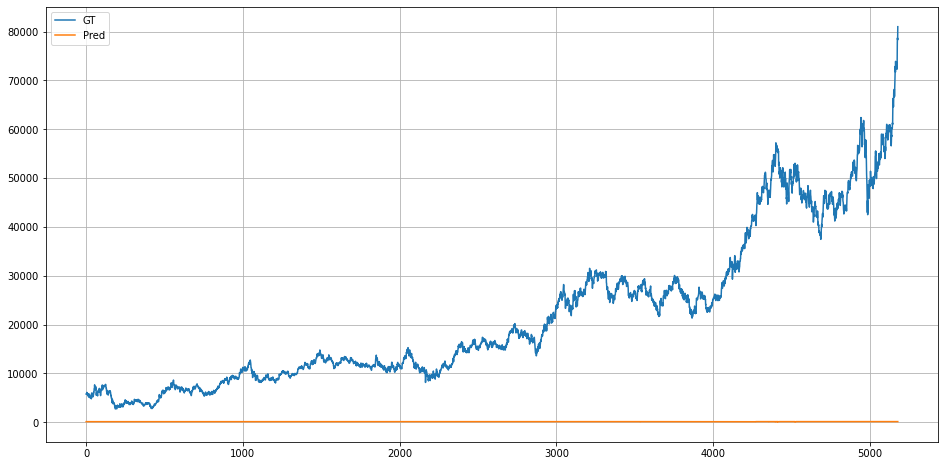

7 100 132783440.0
7 200 799583744.0
7 300 1919990272.0


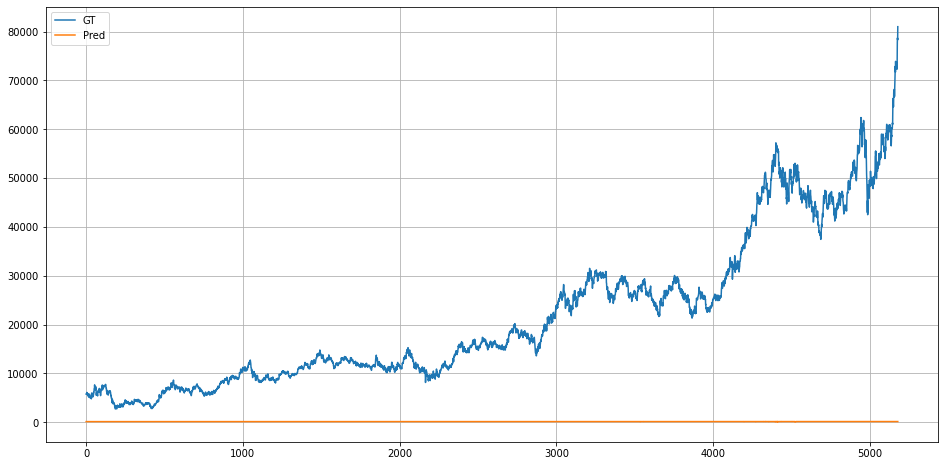

8 100 132433344.0
8 200 798724160.0
8 300 1918660608.0


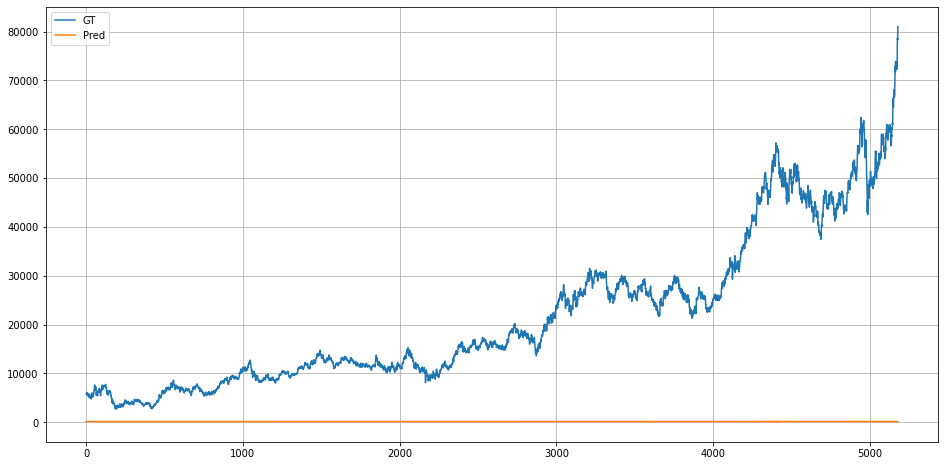

9 100 132084064.0
9 200 797864320.0
9 300 1917331200.0


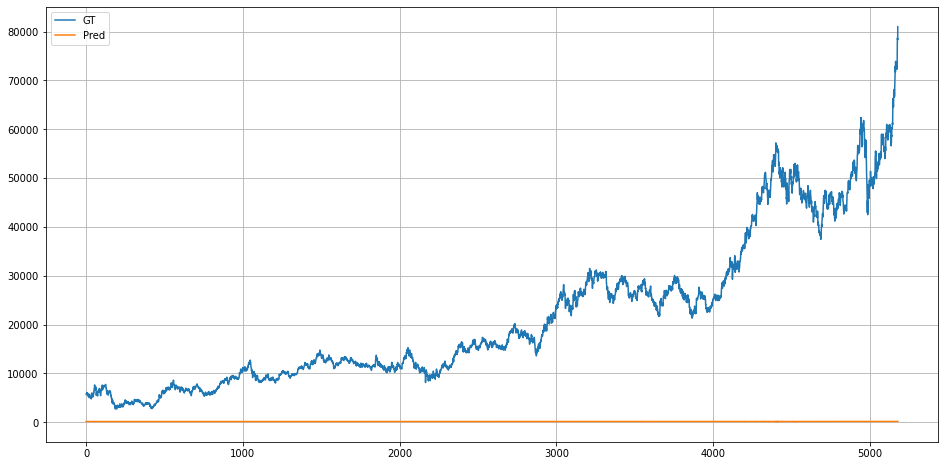

In [29]:
losses = []

for epoch in range(nb_epochs):
    train_loss = []
    pred_close = []

    for batch_idx, samples in enumerate(dataloader_train, start=1):

        x_train, y_train = samples

        # seq별 hidden state reset
        model.reset_hidden_state()

        # H(x) 계산
        outputs = model(x_train)
        pred_close.extend(outputs.squeeze().tolist())

        # cost 계산
        loss = criterion(outputs, y_train)
        train_loss.append(loss.detach().cpu().item())

        # cost로 H(x) 개선
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(epoch, batch_idx, loss.item())
            
    y_true = df[:'2020']['Close'].values[5:]
#     y_pred = mms_y2.inverse_transform([pred_close]).squeeze()
    y_pred = pred_close
    
    plt.figure(figsize=(16,8))
    plt.plot(y_true)
    plt.plot(y_pred)
    plt.legend(['GT', 'Pred'])
    plt.grid(True)
    plt.show()

    losses.append(sum(train_loss)/len(train_loss))

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()
pred_close = []
with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test, start=1):
        x_train, y_train = samples
        
        # seq별 hidden state reset
        model.reset_hidden_state()

        # H(x) 계산
        outputs = model(x_train)
        pred_close.extend(outputs.squeeze().tolist())

        # cost 계산
        loss = criterion(outputs, y_train)

In [ ]:
y_true = df['2020':]['Close'].values[5:]
y_pred = mms_y.inverse_transform([pred_close]).squeeze()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_true)
plt.plot(y_pred)
# plt.xlim(0,200)
plt.legend(['GT', 'Pred'])
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true, y_pred)

## 참고자료
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

- https://eunhye-zz.tistory.com/entry/Pytorch%EB%A5%BC-%ED%99%9C%EC%9A%A9%ED%95%9C-Timeseries-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%8D%B81-LSTM

<br>

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 모든 자료의 저작권은 성민석에 있으며 제작자의 동의없이 외부로의 무단 복제, 배포 및 전송을 절대로 불허합니다.

<b>Copyright ⓒ 2022. Minsuk Sung. All rights reserved.</b>
</span>

<br>